# Inverse kinematics fit from the fly hackathon

In [1]:
from os import path as op
import sys
sys.path.insert(0, op.abspath('/Users/eabe/Research/MyRepos/BiomechControl/models/fruitfly_v2/'))
sys.path.insert(0, op.abspath('/Users/eabe/Research/Github/flybody'))

from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import PIL.ImageDraw
from tqdm import tqdm

from dm_control import mujoco
from dm_control import mjcf
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper import mjbindings

import sys
sys.path.append('..')

from flybody.inverse_kinematics import qpos_from_site_xpos
from flybody.utils import display_video
from flybody.tasks.task_utils import retract_wings

In [2]:
def transform_frame(frame):
    """Transform a single frame from data to model reference frame."""
    # Rotate around z-axis.
    frame = frame[:, [1, 0, 2]]
    frame[:, 1] *= -1
    # Change units mm to cm.
    frame *= 0.1
    return frame

# Load a single walking sequence

In [3]:
base_path = Path('/Users/eabe/Research/MyRepos/mujoco_mpc/Archive/fruitfly')
task_path = Path('/Users/eabe/Research/MyRepos/mujoco_mpc/mjpc/tasks/fruitfly/flytrackingqpos')

data_path = base_path / 'combined_wt_berlin_walking_v3.pq'
full_df = pd.read_parquet(data_path, engine='pyarrow')
bout_stats = full_df.groupby(['walking_bout_number','fullfile','Sex'])[['fictrac_delta_rot_lab_y_mms', 'fictrac_delta_rot_lab_z_deg/s']].agg(['mean','min','max','std','count'])
fast = (bout_stats[('fictrac_delta_rot_lab_y_mms','mean')] >= 12) & (bout_stats[('fictrac_delta_rot_lab_y_mms','min')] >= 10)
straight = (bout_stats[('fictrac_delta_rot_lab_z_deg/s','mean')].abs() <= 45) &\
           (bout_stats[('fictrac_delta_rot_lab_z_deg/s','min')] >= -60) &\
           (bout_stats[('fictrac_delta_rot_lab_z_deg/s','max')] <= 60)

#minlen =  bout_stats[('fictrac_delta_rot_lab_z_deg/s','count')] >= 300
bout_stats[fast & straight].sort_values(('fictrac_delta_rot_lab_y_mms','min'))

fictrac_delta_rot_lab_y_mms  \
                                                                                                     mean   
walking_bout_number fullfile                                           Sex                                  
12509.0             6.5.20|Fly 4_0|06052020_fly4_0 R3C5  str-cw-0.1... Male                     17.916918   
6544.0              5.13.21|Fly 2_0|05132021_fly2_0 R3C1  str-cw-0 sec Female                   15.993181   
9847.0              6.5.20|Fly 4_0|06052020_fly4_0 R2C15  rot-cw-0 sec Male                     14.946284   
14771.0             6.15.20|Fly 4_0|06152020_fly4_0 R3C20  rot-cw-0... Female                   14.525964   
4242.0              6.10.20|Fly 1_0|06102020_fly1_0 R3C20  rot-cw-0... Female                   16.907913   
11706.0             6.11.20|Fly 3_0|06112020_fly3_0 R2C26  rot-ccw-... Female                   15.831629   
3962.0              6.10.20|Fly 1_0|06102020_fly1_0 R3C11  str-ccw-... Female                   17.166075   
14578.0             9.19.23|Fly 5_0|09192023_fly5_0 R4C4  str-cw-1 sec Male                     17.642221   
12318.0             6.5.20|Fly 4_0|06052020_fly4_0 R2C7  str-cw-0.7... Male                     18.367041   
2543.0              5.27.19|Fly 1_0|05272019_fly1_0 R1C13  str-ccw-... Male                     16.946284   
12970.0             9.19.23|Fly 5_0|09192023_fly5_0 R5C8  str-ccw-1... Male                     19.061747   
9586.0              6.5.20|Fly 4_0|06052020_fly4_0 R1C20  rot-cw-0.... Male                     18.101082   
12516.0             6.5.20|Fly 4_0|06052020_fly4_0 R3C6  str-cw-0.3... Male                     19.114001   
9401.0              6.5.20|Fly 4_0|06052020_fly4_0 R1C6  str-cw-0.3... Male                     18.338619   
7809.0              6.10.20|Fly 3_0|06102020_fly3_0 R2C9  str-ccw-0... Female                   18.752164   
14574.0             9.19.23|Fly 5_0|09192023_fly5_0 R4C3  str-cw-0.... Male                     20.339991   
9625.0              6.5.20|Fly 4_0|06052020_fly4_0 R1C23  rot-ccw-0... Male                     19.877269   

                                                                                          \
                                                                                     min   
walking_bout_number fullfile                                           Sex                 
12509.0             6.5.20|Fly 4_0|06052020_fly4_0 R3C5  str-cw-0.1... Male    10.206595   
6544.0              5.13.21|Fly 2_0|05132021_fly2_0 R3C1  str-cw-0 sec Female  10.287758   
9847.0              6.5.20|Fly 4_0|06052020_fly4_0 R2C15  rot-cw-0 sec Male    10.360710   
14771.0             6.15.20|Fly 4_0|06152020_fly4_0 R3C20  rot-cw-0... Female  10.613337   
4242.0              6.10.20|Fly 1_0|06102020_fly1_0 R3C20  rot-cw-0... Female  10.676037   
11706.0             6.11.20|Fly 3_0|06112020_fly3_0 R2C26  rot-ccw-... Female  11.267204   
3962.0              6.10.20|Fly 1_0|06102020_fly1_0 R3C11  str-ccw-... Female  11.466842   
14578.0             9.19.23|Fly 5_0|09192023_fly5_0 R4C4  str-cw-1 sec Male    11.474303   
12318.0             6.5.20|Fly 4_0|06052020_fly4_0 R2C7  str-cw-0.7... Male    11.541010   
2543.0              5.27.19|Fly 1_0|05272019_fly1_0 R1C13  str-ccw-... Male    11.621863   
12970.0             9.19.23|Fly 5_0|09192023_fly5_0 R5C8  str-ccw-1... Male    13.553560   
9586.0              6.5.20|Fly 4_0|06052020_fly4_0 R1C20  rot-cw-0.... Male    13.736252   
12516.0             6.5.20|Fly 4_0|06052020_fly4_0 R3C6  str-cw-0.3... Male    14.160490   
9401.0              6.5.20|Fly 4_0|06052020_fly4_0 R1C6  str-cw-0.3... Male    14.222288   
7809.0              6.10.20|Fly 3_0|06102020_fly3_0 R2C9  str-ccw-0... Female  14.362022   
14574.0             9.19.23|Fly 5_0|09192023_fly5_0 R4C3  str-cw-0.... Male    14.555319   
9625.0              6.5.20|Fly 4_0|06052020_fly4_0 R1C23  rot-ccw-0... Male    16.949504   

                                                        

In [6]:
walking_bout_n = 1
df = full_df[full_df['walking_bout_number'] == 14574]
df.shape

(181, 452)

In [5]:
# full_df['walking_bout_number'].unique()
walking_bout_n = 2
df = full_df[full_df['walking_bout_number'] == 2244]
df.shape

(157, 452)

In [ ]:
plt.plot(np.deg2rad(df['L1A_abduct']))

# Load the fly model

In [10]:
xml_path = task_path / 'task.xml'
# xml_path = task_path.parent / 'fruitfly_force.xml'
mjcf_model = mjcf.from_path(xml_path)

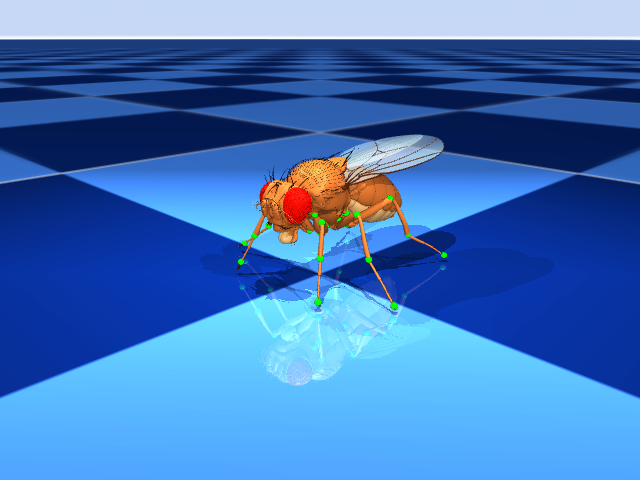

In [11]:
# Visualize fly as loaded.
physics = mjcf.Physics.from_mjcf_model(mjcf_model)
# physics.model.geom('floor').pos = (0, 0, -.137)
_ = physics.reset()
# retract_wings(physics, prefix='')
# physics.step()
pixels = physics.render(camera_id=1, width=640, height=480)
PIL.Image.fromarray(pixels)

In [12]:
legs = ['T1_left', 'T1_right', 'T2_left', 'T2_right', 'T3_left', 'T3_right']
joints = ['coxa', 'femur', 'tibia', 'tarsus']
xpos_geoms = ['coxa', 'femur', 'tibia', 'tarsus', 'claw']
joint_names = [f'{joint}_{leg}' for leg in legs for joint in joints]
xpos_names = [f'{joint}_{leg}' for leg in legs for joint in xpos_geoms]
# physics.named.data.framepos[pos_names]
site_names = [f'tracking[{joint_name}]' for joint_name in xpos_names]

legs_data = ['L1', 'R1', 'L2','R2', 'L3','R3']
joints_data = ['A','B','C','D','E']
coords_data = ['_x','_y','_z']
joint_pos_columns = [leg + joint + coord 
                     for leg in legs_data
                     for joint in joints_data 
                     for coord in coords_data]

# Generate joint sequences in model and data in matching order

In [13]:
# Model.
# mjcf_model = mjcf.from_path(xml_path)
# legs = ['T1_left', 'T1_right', 'T2_left', 'T2_right', 'T3_left', 'T3_right']
# joints = ['coxa', 'femur', 'tibia', 'tarsus', 'claw']
# joint_names = [f'{joint}_{leg}' for leg in legs for joint in joints]

# Data.
legs_data = ['L1', 'R1', 'L2','R2', 'L3','R3']
joints_data = ['A','B','C','D','E']
coords_data = ['_x','_y','_z']
joint_pos_columns = [leg + joint + coord 
                     for leg in legs_data
                     for joint in joints_data 
                     for coord in coords_data]

In [14]:
for joint in joint_names:
    mjcf_model.find('joint', joint)


# Visualize a single frame

Text(0.5, 1.0, 'side view')

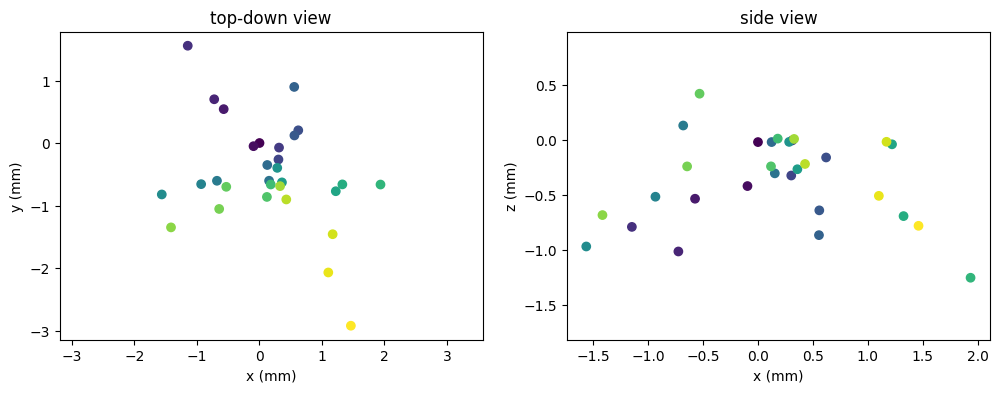

In [15]:
frame_idx = 0
test_frame = df[joint_pos_columns].values[frame_idx, :].reshape(30, 3)  # (keypoint, xyz)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(test_frame[:, 0], test_frame[:, 1], c=np.arange(30))
plt.axis('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('top-down view')
plt.subplot(1, 2, 2)
plt.scatter(test_frame[:, 0], test_frame[:, 2], c=np.arange(30))
plt.axis('equal')
plt.xlabel('x (mm)')
plt.ylabel('z (mm)')
plt.title('side view')

# Compare model's initial position with first data frame

In [16]:
# Get the first frame.
frame0 = df[joint_pos_columns].values[0, :].reshape(30, 3)  # (keypoint, xyz)
frame0 = transform_frame(frame0)
site_pos = physics.named.data.site_xpos[site_names]
# Shift to match origin of data and model.
frame0 += site_pos[0, :]  # Body-coxa T1 left joint is the data origin.

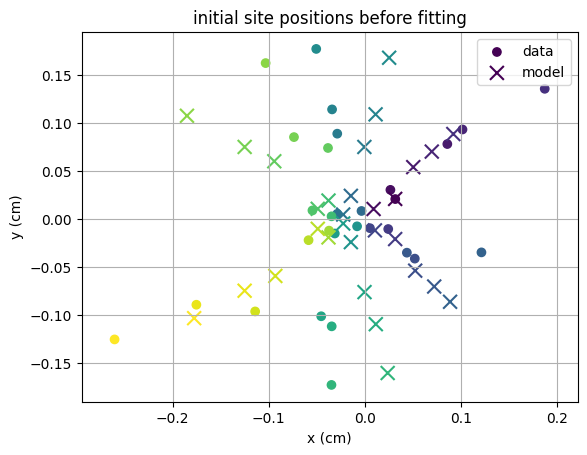

In [17]:
plt.scatter(frame0[:, 0], frame0[:, 1], c=np.arange(30), label='data')
plt.scatter(site_pos[:, 0], site_pos[:, 1], marker='x', s=100, c=np.arange(30), label='model')
plt.axis('equal')
plt.title('initial site positions before fitting')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.legend()
plt.grid()

# Try fitting one frame

In [18]:
# Manipulate all joints for now.
joints_to_manipulate = [j.name for j in mjcf_model.find_all('joint')]

In [19]:
frame0.shape, len(joints_to_manipulate), len(site_names)

((30, 3), 67, 30)

In [20]:
_ = physics.reset()
# retract_wings(physics, prefix='')

# Run IK fit on one frame.
res = qpos_from_site_xpos(physics, site_names, frame0, joints_to_manipulate, inplace=True)

In [21]:
res.qpos

array([ 6.73104585e-03, -3.23107290e-03,  4.07589841e-03,  9.92827794e-01,
        4.31623492e-02,  1.07582046e-01,  2.92589630e-02, -1.41547088e-02,
        5.82218692e-01,  9.18853309e-01,  1.48972217e+00,  3.55363202e-01,
        1.07524366e+00,  8.96987770e-01,  3.34168489e-02,  2.13597057e-02,
        1.02962777e-01, -7.74088799e-02,  1.33882044e-01,  1.97729133e-01,
        2.63436641e-02, -1.14474323e-02, -4.05970547e-01, -3.81675254e-01,
        1.31111498e+00, -4.43166930e-02, -5.51159291e-02, -2.71758297e-01,
       -1.15312527e+00, -1.56687428e-01, -3.37718412e-01,  2.70608928e-01,
        4.52656885e-01, -2.49967569e-01, -8.45252478e-02,  1.10220514e-01,
        3.24024803e-02,  5.87801288e-03,  1.88339765e-02, -1.46970596e-03,
       -1.06086245e-01, -6.60537060e-01,  6.08742726e-01,  9.73379802e-01,
       -7.74381059e-01, -4.49430866e-02,  1.63425491e-01,  3.11447572e-03,
        1.89299704e-02,  7.81119940e-02,  7.66060236e-02, -3.96708819e-01,
        6.66400302e-01, -

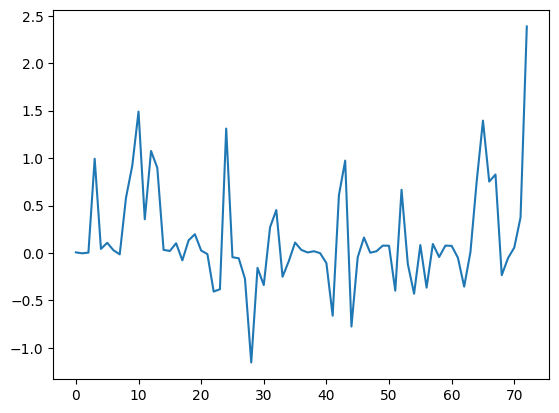

In [22]:
plt.plot(res.qpos)


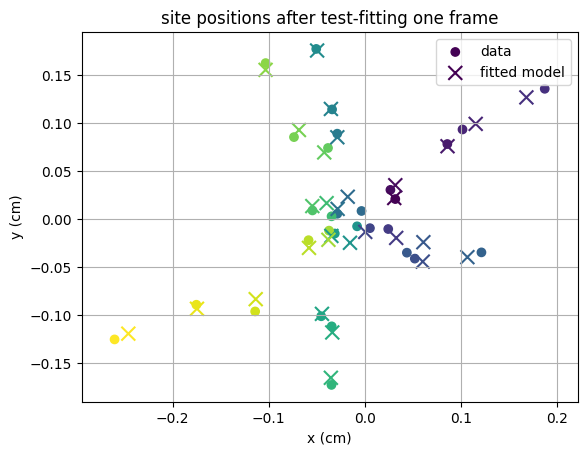

In [23]:
# Compare site positions after fitting.
site_pos = physics.named.data.site_xpos[site_names]
plt.scatter(frame0[:, 0], frame0[:, 1], c=np.arange(30), label='data')
plt.scatter(site_pos[:, 0], site_pos[:, 1], marker='x', s=100, c=np.arange(30), label='fitted model')
plt.axis('equal')
plt.title('site positions after test-fitting one frame')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.legend()
plt.grid()

In [ ]:
# #add ball
# texture = mjcf_model.asset.add('texture', rgb1=[.2, .3, .4], rgb2=[.1, .2, .3],
#                                type='2d', builtin='checker', name='groundplane',
#                                width=200, height=200,)
# material = mjcf_model.asset.add('material', name='ballsurface', 
#                                 texrepeat=[2, 2],  # Makes white squares exactly 1x1 length units.
#                                 texuniform=True,
#                                 reflectance=0.2,
#                                 texture=texture)

# # Remove freejoint.
# freejoint = mjcf_model.find('joint', 'free')
# if freejoint is not None:
#     freejoint.remove()
    
# # == Add ball.
# radius = 0.454  # Pick ball radius.
# # Calculate ball position wrt fly given ball radius.
# claw_T1_left = np.array([0.09178167, 0.08813114, -0.12480448])
# ball_x = - 0.05
# ball_z = - np.sqrt(radius**2 
#                    - (claw_T1_left[0] - ball_x)**2 
#                    - claw_T1_left[1]**2) + claw_T1_left[2]
# ball = mjcf_model.worldbody.add('body', name='ball', pos=(ball_x, 0, ball_z))
# ball.add('geom', type='sphere', size=(radius, 0, 0),
#          material=material, density=0.1)  # Density of water in cgs == 1.
# ball_joint = ball.add('joint', name='ball', type='ball')

# # Exclude "surprising collisions".
# for child in mjcf_model.find('body', 'thorax').all_children():
#     if child.tag == 'body':
#         mjcf_model.contact.add('exclude', name=f'thorax_{child.name}',
#                                body1='thorax', body2=child.name)

In [ ]:
for n in range(1, 100):
    physics.step()

In [ ]:
# physics = mjcf.Physics.from_mjcf_model(mjcf_model)
# physics.model.geom('floor').pos = (0, 0, -.137)
_ = physics.reset()
# Visualize model fitted to first frame.
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
pixels = physics.render(camera_id=0, width=640, height=480,scene_option=scene_option)
PIL.Image.fromarray(pixels)

# Try fitting all frames

In [24]:
i = 0
frame = df[joint_pos_columns].values[i, :].reshape(30, 3)  # (keypoint, xyz)
frame = transform_frame(frame)
frame += site_pos[0, :]  # Shift to body-coxa T1 left joint.
# Run IK fit on current frame.
_ = physics.reset()

res = qpos_from_site_xpos(physics, site_names, frame, joints_to_manipulate, inplace=True)

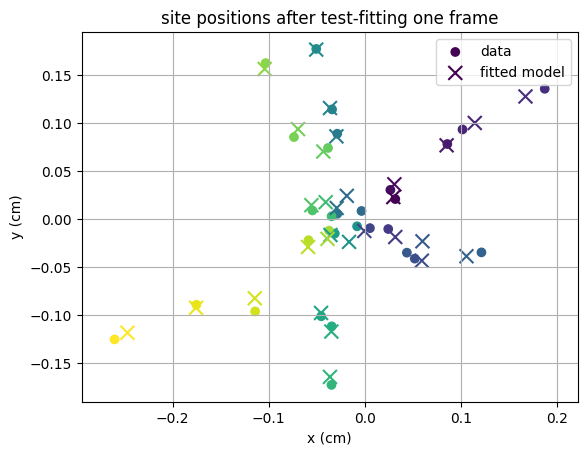

In [25]:
# Compare site positions after fitting.
site_pos = physics.named.data.site_xpos[site_names]
plt.scatter(frame0[:, 0], frame0[:, 1], c=np.arange(30), label='data')
plt.scatter(site_pos[:, 0], site_pos[:, 1], marker='x', s=100, c=np.arange(30), label='fitted model')
plt.axis('equal')
plt.title('site positions after test-fitting one frame')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.legend()
plt.grid()

In [27]:
_ = physics.reset()
# retract_wings(physics, prefix='')

site_pos = physics.named.data.site_xpos[site_names]
joints_to_manipulate = [j.name for j in mjcf_model.find_all('joint')]
# joints_to_manipulate = joint_names

qpos = []
all_frames = []
n_frames = len(df[joint_pos_columns].values)
for i in tqdm(range(n_frames)):
    # Prepare frame for fitting.
    frame = df[joint_pos_columns].values[i, :].reshape(30, 3)  # (keypoint, xyz)
    frame = transform_frame(frame)
    frame += site_pos[0, :]  # Shift to body-coxa T1 left joint.
    all_frames.append(frame)
    # _ = physics.reset()
    # Run IK fit on current frame.
    res = qpos_from_site_xpos(physics, site_names, frame, joints_to_manipulate, inplace=True)
    # Store qpos results.
    qpos.append(res.qpos.copy())
all_frames = np.stack(all_frames)
qpos = np.stack(qpos)


100%|██████████| 181/181 [01:11<00:00,  2.53it/s]


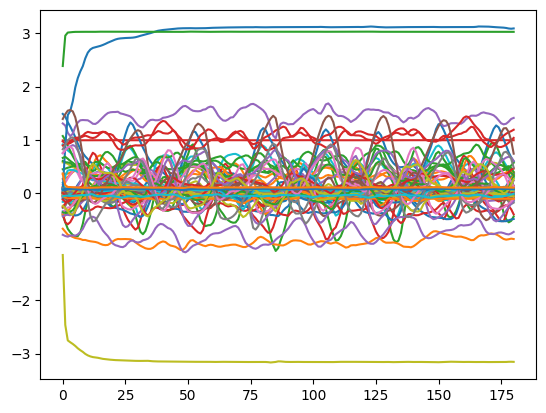

In [28]:
plt.plot(qpos)

In [ ]:
t = 0
# Compare site positions after fitting.
frame= all_frames[t]
# res = qpos_from_site_xpos(physics, site_names, frame, joints_to_manipulate, inplace=True)
# with physics.reset_context():
#     physics.data.qpos = res.qpos.copy()
_ = physics.reset()
site_pos = physics.named.data.site_xpos[site_names]
plt.scatter(all_frames[t,:, 0], all_frames[t,:, 1], c=np.arange(30), label='data')
plt.scatter(site_pos[:, 0], site_pos[:, 1], marker='x', s=100, c=np.arange(30), label='fitted model')
plt.axis('equal')
plt.title('site positions after test-fitting one frame')
plt.xlabel('x (cm)')
plt.ylabel('y (cm)')
plt.legend()
plt.grid()

In [ ]:
qpos = np.concatenate([np.zeros((qpos.shape[0],6)), qpos], axis=1)

In [36]:
qpos_stand = qpos[0,:] #np.array([0,0,0,0,0,0,0,0, 0, 0.000178521, -1.07906e-05, 0, 0.00022365, 0.00012099, 0, 0, 0, 0, 0, 0, -8.21227e-05, 1.7515e-05, 0, -6.83271e-05, -1.73481e-05, 0, 0, 0, 0, 0, 0, -7.29514e-05, 8.13461e-05, 0, -4.55924e-05, 1.73673e-05, 0, 0, 0, 0, 0, 0, -0.000200893, 0.000243786, 0, -9.05341e-05, -1.9564e-05, 0, 0, 0, 0, 0, 0, 0.000307064, -0.000344922, 0, 2.74459e-05, 5.30669e-06, 0, 0, 0, 0, 0, 0, 0.000162806, -7.42181e-05, 0, 0.000232139, 7.99452e-05, 0, 0, 0, 0])
qvel = np.diff(qpos, axis=0, prepend=qpos[0:1,:])
qvel = qvel[:,1:]

In [37]:
qpos.shape, qvel.shape, physics.data.qpos.shape, all_frames.shape, qpos_stand.shape

((181, 73), (181, 72), (73,), (181, 30, 3), (73,))

In [ ]:
physics.named.data.qvel

In [38]:
interp_time = np.linspace(0,all_frames.shape[0],10*all_frames.shape[0])
time = np.linspace(0,all_frames.shape[0],all_frames.shape[0])
mod_frames = np.zeros((interp_time.shape[0],all_frames.shape[1],all_frames.shape[2]))
qpos_frames = np.zeros((interp_time.shape[0],qpos.shape[1]))
qvel_frames = np.zeros((interp_time.shape[0],qvel.shape[1]))
for n in range(all_frames.shape[1]):
    for m in range(all_frames.shape[2]):
        mod_frames[:,n,m] = np.interp(interp_time, time, all_frames[:,n,m])
for n in range(qpos.shape[1]):
    qpos_frames[:,n] = np.interp(interp_time, time, qpos[:,n])
for n in range(qvel.shape[1]):    
    qvel_frames[:,n] = np.interp(interp_time, time, qvel[:,n])


In [39]:
# mod_frames = all_frames.copy()
mod_frames[:,:,-1] = mod_frames[:,:,-1]+0.02
mod_frames[:,:,-1] = np.clip(mod_frames[:,:,-1],-0.137,10)
print(np.min(mod_frames[:,:,-1]),np.max(mod_frames[:,:,-1]))

-0.13247021216983024 0.035040498433348166


In [40]:
mod_frames.shape, qpos.shape, qvel.shape    

((1810, 30, 3), (181, 73), (181, 72))

In [41]:
root = mjcf.RootElement()
root.keyframe.add('key', name=f'walk{walking_bout_n}_1', mpos=mod_frames[0].flatten(),qpos=qpos_frames[0].flatten(),qvel=qvel_frames[0].flatten())
for n in tqdm(range(2,mod_frames.shape[0])):
    root.keyframe.add('key', name=f'walk{walking_bout_n}_{n}', mpos=mod_frames[n].flatten(),qpos=qpos_frames[n].flatten())
    
# save xml file
keyframe_path = task_path / 'keyframes/'
mjcf.export_with_assets(root, keyframe_path, f'Fly_walk_free_qpos{walking_bout_n}.xml')
keyframe_path/f'Fly_walk_qpos{walking_bout_n}.xml'

100%|██████████| 1808/1808 [00:00<00:00, 41116.39it/s]


PosixPath('/Users/eabe/Research/MyRepos/mujoco_mpc/mjpc/tasks/fruitfly/flytrackingqpos/keyframes/Fly_walk_qpos1.xml')

In [ ]:
root = mjcf.RootElement()
root.keyframe.add('key', name=f'walk{walking_bout_n}_1', mpos=mod_frames[0].flatten(),qpos=qpos[0].flatten(),qvel=qvel.flatten())
for n in range(2,mod_frames.shape[0]):
    root.keyframe.add('key', name=f'walk{walking_bout_n}_{n}', mpos=mod_frames[n].flatten())
    
# save xml file
keyframe_path = task_path / 'keyframes/'
mjcf.export_with_assets(root, keyframe_path,f'Fly_walk_free_pos{walking_bout_n}.xml')
keyframe_path/f'Fly_walk_pos{walking_bout_n}.xml'

In [ ]:
physics.reset()

In [ ]:
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 1]
physics.data.mocap_pos = mod_frames_stand[0]
physics.data.qpos = qpos_stand

In [ ]:
for t in range(1000):
    physics.step()
pixels = physics.render(camera_id=1, width=640, height=480, scene_option=scene_option)
qpos_stand = physics.named.data.qpos
qvel_stand = physics.named.data.qvel
mod_frames_stand = np.repeat(np.stack([physics.named.data.xpos[xpos_names[n]] for n in range(len(xpos_names))])[None,:,:],10,axis=0)
PIL.Image.fromarray(pixels)

In [ ]:
qpos_stand.shape,qvel_stand.shape, mod_frames_stand.shape

In [ ]:
t = 0
root = mjcf.RootElement()
root.keyframe.add('key', name=f'stand{walking_bout_n}_1', mpos=physics.named.data.mocap_pos.flatten(),qpos=qpos_stand.flatten(),qvel=qvel_stand.flatten())
for n in range(2,mod_frames_stand.shape[0]):
    root.keyframe.add('key', name=f'stand{walking_bout_n}_{n}', mpos=physics.named.data.mocap_pos.flatten())
    
# save xml file
root.default.remove()
keyframe_path = task_path / 'keyframes/'
mjcf.export_with_assets(root, keyframe_path,f'Fly_stand_free_pos{walking_bout_n}.xml')
keyframe_path/f'Fly_stand_pos{walking_bout_n}.xml'

In [44]:
physics.named.data.qpos

FieldIndexer(qpos):
 0                 free [ 0.00467 ]
 1                 free [ 0.00214 ]
 2                 free [ 0.00636 ]
 3                 free [ 0.997   ]
 4                 free [-0.00881 ]
 5                 free [ 0.0748  ]
 6                 free [ 0.026   ]
 7  coxa_abduct_T1_left [ 0.00316 ]
 8   coxa_twist_T1_left [ 0.382   ]
 9         coxa_T1_left [ 0.378   ]
10        femur_T1_left [ 0.6     ]
11  femur_twist_T1_left [ 0.352   ]
12        tibia_T1_left [ 0.144   ]
13       tarsus_T1_left [ 1.19    ]
14      tarsus2_T1_left [ 0.0508  ]
15      tarsus3_T1_left [ 0.0183  ]
16      tarsus4_T1_left [ 0.11    ]
17      tarsus5_T1_left [-0.0896  ]
18 coxa_abduct_T1_right [ 0.0839  ]
19  coxa_twist_T1_right [ 0.287   ]
20        coxa_T1_right [ 0.375   ]
21       femur_T1_right [ 0.332   ]
22 femur_twist_T1_right [-0.431   ]
23       tibia_T1_right [ 0.136   ]
24      tarsus_T1_right [ 1.41    ]
25     tarsus2_T1_right [-0.0436  ]
26     tarsus3_T1_right [ 0.061   ]
27     t

In [ ]:
mod_frames_stand.flatten()

In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mod_frames_stand[0,:,0], mod_frames_stand[0,:,1], mod_frames_stand[0,:,2], c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [ ]:
np.set_printoptions(suppress=True)
# print(["{:.02f}".format(qqpos) for qqpos in physics.data.qpos])

In [34]:
# Generate video of fitted poses.

camera_id = 5 # Side view.

# Hide all sites.
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 0, 0, 0]
scene_option.flags[enums.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True


#retract_wings(physics)

video_frames = []
for q in tqdm(qpos):
    with physics.reset_context():
        physics.data.qpos = q.copy()
    pixels = physics.render(camera_id=camera_id, width=640, height=480, scene_option=scene_option)
    video_frames.append(pixels)

100%|██████████| 181/181 [00:03<00:00, 53.47it/s]


In [35]:
display_video(video_frames, framerate=30)

In [ ]:
plt.plot(qpos_frames)